In [36]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm, tnrange
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem import Draw

# also see:
# https://greglandrum.github.io/rdkit-blog/posts/2023-01-18-fingerprint-generator-tutorial.html

A simple function to create a Morgan fingerprint as a numpy array

In [31]:
def fp_as_array(mol):
    # deprecated (works with warning)
    # AllChem.GetMorganFingerprintAsBitVect(mol, 2)
    
    mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=2048)
    fp = mfpgen.GetFingerprint(mol) 
    arr = np.zeros((1,), int)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

Build a dataframe from a SMILES file:
Read the SMILES
Calculate a Morgan fingerprint and put that into the dataframe

In [32]:
def build_dataframe(input_file_name):
    df = pd.read_csv(input_file_name,header=None,sep=" ")
    df.columns = ["SMILES","Name","IC50"]
    df['mol'] = [Chem.MolFromSmiles(x) for x in df.SMILES]
    df['morgan'] = [fp_as_array(x) for x in df.mol]
    return df

Benchmark a dataset:

Split into training and test sets using the sklearn defaults
Train and test an XGBoost regressor with Morgan fingerprints and record the R2

In [33]:
def benchmark_dataset(df,cv_folds=10):
    r2_list = []
    for i in tnrange(cv_folds):
        train, test = train_test_split(df)
        xgb = GradientBoostingRegressor()
        xgb.fit(np.array([x for x in train.morgan.values]),train.IC50)
        pred = xgb.predict(np.array([x for x in test.morgan.values]))
        r2 = r2_score(test.IC50,pred)
        r2_list.append(r2)
        
    return np.array(r2_list)

Run the bechmark on a file containing a list of SMILES and IC50 values

In [34]:
# 1,705 measured IC50 values for Estrogen receptor alpha
# J. Chem. Inf. Model. 2019, 59, 3, 1269–1281. DOI: 10.1021/acs.jcim.8b00542

df = build_dataframe('estrogen.smi')
benchmark_dataset(df)

  0%|          | 0/10 [00:00<?, ?it/s]

array([0.77113274, 0.75007975, 0.71165026, 0.72354391, 0.72659363,
       0.75007364, 0.72096839, 0.78055465, 0.73410058, 0.73487578])

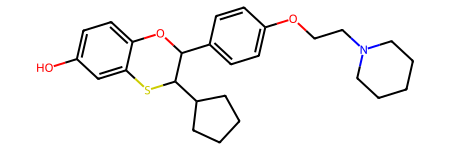

In [35]:
df.iloc[0].mol

In [29]:
df.iloc[0].morgan

array([0, 0, 1, ..., 0, 0, 0])